# **Project Introduction**

## Dataset description

Estimation of HDB Resale Flats Pricing in Singapore using Machine Learning
The dataset comprises of HDB resale transaction prices in Singapore from 2017-2022. Housing Development Board (HDB) has published this housing data containing 10 distinct types of metrics such as month registered for resale, town, flat types, etc. As the data is published by the Singapore government, it is characterized by a high degree of reliability and accuracy.

## Motivation/Problem Statement


This project is crucial in addressing the rising demand for housing in the face of a growing population and escalating costs in land-scarce Singapore. Given the rising concerns about affordability, the project aims to assist individuals in estimating resale flat prices. By doing so, it empowers them to strategically plan and explore housing options that align with their financial constraints and specific preferences. The project's primary focus lies in harnessing and leveraging machine learning techniques to predict resale flat prices accurately.


## Key Questions:

1. What are the primary factors affecting the price of resale flats in Singapore?
2. Which features should we use for our predictive model?
3. What are some limitations/biases that might occur in the predictive model?
4. Will the model be able to capture temporal trends in the market?
5. How will the model be affected by outliers that indicate high levels of risk?


By addressing these key questions, this project aims to provide a valuable tool for individuals in Singapore to better plan and navigate the complex housing market, ultimately helping them make more informed decisions when buying or selling resale flats.

# **Getting Started**

Clone the git repository into your local directory





git clone https://github.com/Cheenaswee/CS3244-Machines-That-Learn.git

# **Data Extraction, Collection & Preparation**

## Unzipping the Datasets.zip file

Running the code will extract the resale_data.csv into the Dataset folder


In [1]:
import os
import zipfile

zip_directory = r"../CS3244-Machines-That-Learn/Dataset"
zip_file_path = os.path.join(zip_directory, "resale_flat.zip")
extract_to_directory = r"../CS3244-Machines-That-Learn/Dataset"

# Check if the zip file exists
if not os.path.exists(zip_file_path):
    print("Error: Zip file does not exist")
    exit()

# Check if the extraction directory exists
if not os.path.exists(extract_to_directory):
    os.makedirs(extract_to_directory)
    print(f"Created extraction directory: {extract_to_directory}")

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified directory
    zip_ref.extractall(extract_to_directory)
    print("Extraction completed successfully.")

Extraction completed successfully.


# **Import Basic Libraries**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import requests
import re

## Reading in Resale Flat Prices Data

Link to Data: https://www.kaggle.com/datasets/mikelll/singapore-housing-price-20172022

In [3]:
dataset = pd.read_csv(r"../CS3244-Machines-That-Learn/Dataset/resale_flat.csv")

In [4]:
print(dataset)

          month        town  flat_type block        street_name storey_range  \
0       2017-01  ANG MO KIO     2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1       2017-01  ANG MO KIO     3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2       2017-01  ANG MO KIO     3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3       2017-01  ANG MO KIO     3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4       2017-01  ANG MO KIO     3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
...         ...         ...        ...   ...                ...          ...   
134163  2022-08      YISHUN     5 ROOM   850       YISHUN ST 81     01 TO 03   
134164  2022-08      YISHUN  EXECUTIVE   325        YISHUN CTRL     07 TO 09   
134165  2022-08      YISHUN  EXECUTIVE   355     YISHUN RING RD     07 TO 09   
134166  2022-08      YISHUN  EXECUTIVE   355     YISHUN RING RD     07 TO 09   
134167  2022-08      YISHUN  EXECUTIVE   643       YISHUN ST 61     10 TO 12   

        floor_area_sqm      flat_model 

## Issue: Curse of Dimensionality

The "curse of dimensionality" refers to the challenges that arise when working with high-dimensional data such as increased computational complexity and difficulty in visualization and interpretation.

Since our features contain both categorical and numerical data, we would have to apply several techniques to make the data more compatible. For numerical data which are far apart, we will normalize the data to ensure that they have similar ranges. For categorical data, we one-hot encoding or label encoding to encode the categorical data into numerical values. One-hot encoding is particularly useful for categorical variables with no inherent order.

Hence, by ploting a histogram we can determine if our data is currently facing issue by examining the shape and the standard deviation of the plot. 


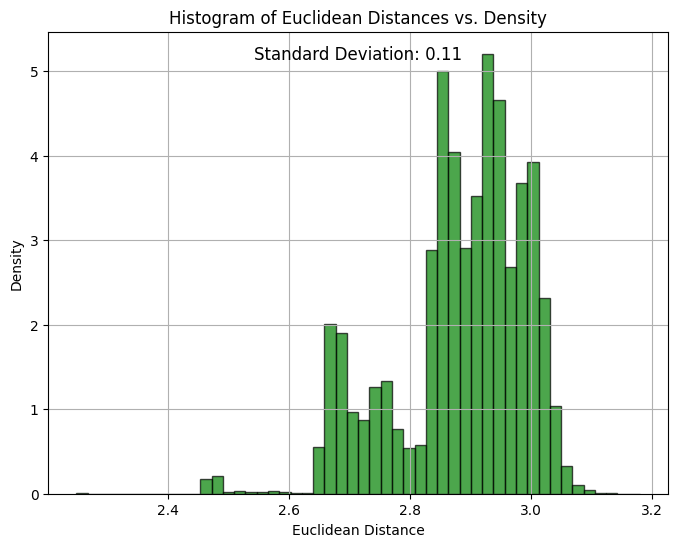

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Filter numeric and categorical columns
numeric_columns = dataset.select_dtypes(include=[np.number]).columns
categorical_columns = dataset.select_dtypes(exclude=[np.number]).columns

# Normalize numeric columns
scaler = MinMaxScaler()  # Use MinMaxScaler for normalization
normalized_numeric_dataset = scaler.fit_transform(dataset[numeric_columns])

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first category to avoid multicollinearity
encoded_categorical_dataset = encoder.fit_transform(dataset[categorical_columns])

# Concatenate normalized numeric and encoded categorical datasets
normalized_dataset = np.concatenate([normalized_numeric_dataset, encoded_categorical_dataset], axis=1)

# Compute Euclidean distances between samples and origin
distances = np.linalg.norm(normalized_dataset, axis=1)

# Calculate standard deviation of Euclidean distances
std_dev = np.std(distances)

# Plot histogram with density
plt.figure(figsize=(8, 6))
plt.hist(distances, bins=50, density=True, edgecolor='black', alpha=0.7, color='green')
plt.title('Histogram of Euclidean Distances vs. Density')
plt.xlabel('Euclidean Distance')
plt.ylabel('Density')
plt.grid(True)

# Add standard deviation to the plot
plt.text(0.5, 0.95, f'Standard Deviation: {std_dev:.2f}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12)

plt.show()



For the plot above, the standard deviation shown is good. However, the distribution of the curve is not very smooth

Likely Cause: Too many features

## Feature Selection
We do feature selection to determine the top 5 features that are most relevant in our dataset. We aim to improve model performance and prevent the "curse of dimensionality"

For our feature selection, we use the method of Random Forest and Recursive Feature Elimination. First, we will find the best number of estimators to use for the Random Forest Model. 




In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import RFE
import re


# Load a subset of the dataset2
dataset2 = pd.read_csv(r"../CS3244-Machines-That-Learn/Dataset/resale_flat.csv").head(10)

# Separate features and target variable
X = dataset.drop(['resale_price', 'month', 'street_name', 'block'], axis=1)  # Drop 'month', 'block' and 'street_name' columns as they will not provide much information
y = dataset['resale_price']

label_encoders = {}

# Encode categorical features 'town' and 'flat_model'
for column in ['town', 'flat_model']:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])

# Display the mapping of encoded numbers to unique values for each categorical feature
# for column in ['town', 'flat_model']:
#     print(f"Unique values for {column}:")
#     for encoded_value, original_label in zip(X[column].unique(), label_encoders[column].inverse_transform(X[column].unique())):
#         print(f"{encoded_value}: {original_label}")
#     print()

#print(X)
# Encode features 'storey_range', 'flat_type', and 'remaining_lease'
# Define functions for encoding
def encode_storey_range(x):
    numbers = [int(s) for s in x.split() if s.isdigit()]
    return np.mean(numbers) if numbers else np.nan

def encode_flat_type(x):
    if x.isdigit():
        return int(x)
    elif x.split()[0].isdigit():
        return int(x.split()[0])
    else:
        return np.nan


def encode_remaining_lease(x):
    return int(x.split()[0]) if x.split()[0].isdigit() else np.nan

# Apply encoding functions to the respective columns
X['storey_range_encoded'] = X['storey_range'].apply(encode_storey_range)
X['flat_type_encoded'] = X['flat_type'].apply(encode_flat_type)
X['remaining_lease_encoded'] = X['remaining_lease'].apply(encode_remaining_lease)

# Initialize LabelEncoder for the new encoded features
for column in ['storey_range_encoded', 'flat_type_encoded', 'remaining_lease_encoded']:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column].astype(str))

# Display the mapping of encoded numbers to unique values for each encoded feature
for column in ['storey_range_encoded', 'flat_type_encoded', 'remaining_lease_encoded']:
    print(f"Unique values for {column}:")
    for encoded_value, original_label in zip(X[column].unique(), label_encoders[column].inverse_transform(X[column].unique())):
        print(f"{encoded_value}: {original_label}")
    print()


# Display the encoded features
print(X)
#print(X.columns)

# Select features for feature selection, excluding 'storey_range', 'flat_model', 'block', and 'remaining_lease_date'
selected_features = ['town', 'flat_model', 'flat_type_encoded', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease_encoded', 'storey_range_encoded']

# Create a new DataFrame with selected features
X_selected = X[selected_features]
#print(X_selected)



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)   #use head(100) on both X_selected and y to check if the code runs)

# Initialize the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Initialize Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf, n_features_to_select=5, step=1)

# Fit RFE on training data
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_selected.columns[rfe.support_]

# Print selected features
print("Selected Features for feature selection:")
print(selected_features)



Unique values for storey_range_encoded:
0: 11.0
3: 2.0
14: 5.0
16: 8.0
1: 14.0
4: 20.0
5: 23.0
2: 17.0
9: 35.0
7: 29.0
10: 38.0
15: 50.0
6: 26.0
11: 41.0
8: 32.0
13: 47.0
12: 44.0

Unique values for flat_type_encoded:
1: 2.0
2: 3.0
3: 4.0
4: 5.0
5: nan
0: 1.0

Unique values for remaining_lease_encoded:
18: 61
17: 60
19: 62
20: 63
15: 58
16: 59
50: 93
51: 94
35: 78
27: 70
24: 67
25: 68
13: 56
23: 66
22: 65
26: 69
21: 64
40: 83
44: 87
28: 71
49: 92
11: 54
39: 82
32: 75
12: 55
31: 74
29: 72
37: 80
43: 86
36: 79
10: 53
14: 57
9: 52
8: 51
52: 95
47: 90
38: 81
42: 85
41: 84
34: 77
45: 88
6: 49
7: 50
46: 89
30: 73
5: 48
33: 76
48: 91
53: 96
4: 47
3: 46
2: 45
54: 97
1: 44
0: 43

        town  flat_type storey_range  floor_area_sqm  flat_model  \
0          0     2 ROOM     10 TO 12            44.0           5   
1          0     3 ROOM     01 TO 03            67.0          12   
2          0     3 ROOM     01 TO 03            67.0          12   
3          0     3 ROOM     04 TO 06            

## Finding the best features with Random Forest and Recursive Feature Elimnation 

We got the following 5 features from feature selection
1. floor_area_sqm
2. lease_commerce_date
3. flat_model
4. town
5. remaining_lease

## Convert non-numerical data into numerical

In [7]:
le_flat_type = LabelEncoder()
dataset['town'] = le_flat_type.fit_transform(dataset['town'])
le_flat_model = LabelEncoder()
dataset['flat_model'] = le_flat_model.fit_transform(dataset['flat_model'])


# Function to convert remaining lease to months
def convert_remaining_lease_to_months(remaining_lease_str):
    parts = remaining_lease_str.split()
    total_months = 0
    
    for i in range(0, len(parts), 2):
        if parts[i+1] == 'years':
            total_months += int(parts[i]) * 12
        elif parts[i+1] == 'months':
            total_months += int(parts[i])
    
    return total_months

# Convert 'remaining_lease' to numerical format in months
dataset['remaining_lease_months'] = dataset['remaining_lease'].apply(convert_remaining_lease_to_months)

print(dataset)

          month  town  flat_type block        street_name storey_range  \
0       2017-01     0     2 ROOM   406  ANG MO KIO AVE 10     10 TO 12   
1       2017-01     0     3 ROOM   108   ANG MO KIO AVE 4     01 TO 03   
2       2017-01     0     3 ROOM   602   ANG MO KIO AVE 5     01 TO 03   
3       2017-01     0     3 ROOM   465  ANG MO KIO AVE 10     04 TO 06   
4       2017-01     0     3 ROOM   601   ANG MO KIO AVE 5     01 TO 03   
...         ...   ...        ...   ...                ...          ...   
134163  2022-08    25     5 ROOM   850       YISHUN ST 81     01 TO 03   
134164  2022-08    25  EXECUTIVE   325        YISHUN CTRL     07 TO 09   
134165  2022-08    25  EXECUTIVE   355     YISHUN RING RD     07 TO 09   
134166  2022-08    25  EXECUTIVE   355     YISHUN RING RD     07 TO 09   
134167  2022-08    25  EXECUTIVE   643       YISHUN ST 61     10 TO 12   

        floor_area_sqm  flat_model  lease_commence_date     remaining_lease  \
0                 44.0          

## Split the dataset into training and testing sets

In [8]:
X = dataset[['town', 'flat_model', 'floor_area_sqm', 'remaining_lease_months']]  
y = dataset['resale_price']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Further split the training set into training and validation sets

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(X_val)

        town  flat_model  floor_area_sqm  remaining_lease_months
80390      0          12            68.0                     711
24836      1          17           117.0                     710
30639      4           8           114.0                     929
133513    20          10            90.0                     922
65349     17           8            92.0                    1133
...      ...         ...             ...                     ...
15948     13          12            91.0                     763
43833      3           8           103.0                     936
73114      1          12            82.0                     682
15691      9          12            67.0                     732
14198     13          13            93.0                    1079

[10734 rows x 4 columns]


By converting non-numerical data into numerical representations, it ensures that our dataset is well-suited for analysis and machine learning model training. Additionally, we split the dataset into training, validation, and test sets to facilitate effective model training, evaluation, and validation. This approach enables us to train models on just a portion of the data, refine them on a separate subset to prevent overfitting, and finally assess their performance on unseen data. By structuring the data in this manner, we ensure the reliability and robustness of the predictive models used in our project.

## Scatter plot between 'floor_area_sqm' and 'resale_price'

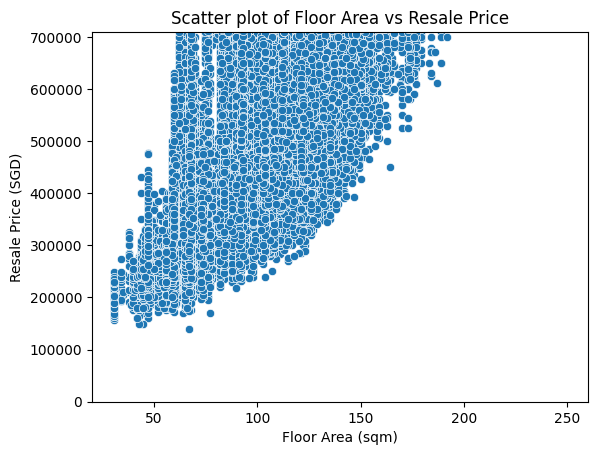

In [10]:
sns.scatterplot(x='floor_area_sqm', y='resale_price', data=dataset)
plt.title('Scatter plot of Floor Area vs Resale Price')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price (SGD)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 0.5)  # Adjust multiplier as needed
plt.show()

## Scatter plot between 'lease_commence_date' and 'resale_price'

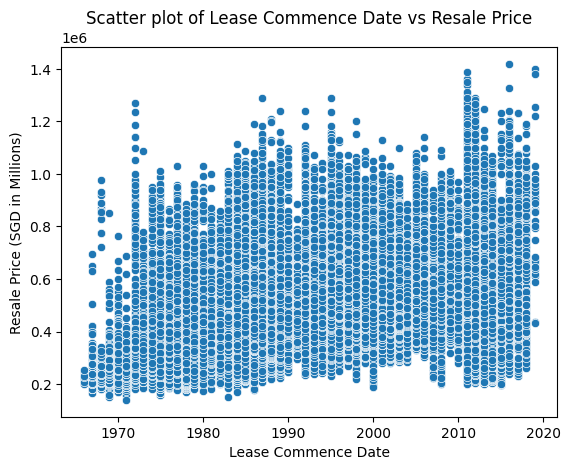

In [16]:
sns.scatterplot(x='lease_commence_date', y='resale_price', data=dataset)
plt.title('Scatter plot of Lease Commence Date vs Resale Price')
plt.xlabel('Lease Commence Date')
plt.ylabel('Resale Price (SGD in Millions)')
plt.show()

## Scatter plot between 'town' and 'resale_price'

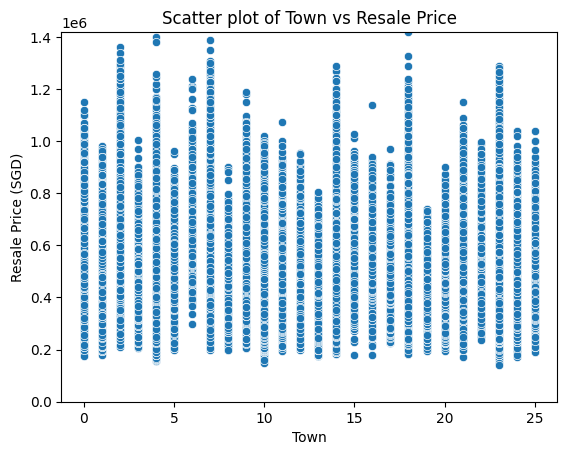

In [17]:
sns.scatterplot(x='town', y='resale_price', data=dataset)
plt.title('Scatter plot of Town vs Resale Price')
plt.xlabel('Town')
plt.ylabel('Resale Price (SGD)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 1)  # Adjust multiplier as needed

plt.show()

## Scatter plot between 'remaining_lease' and 'resale_price'

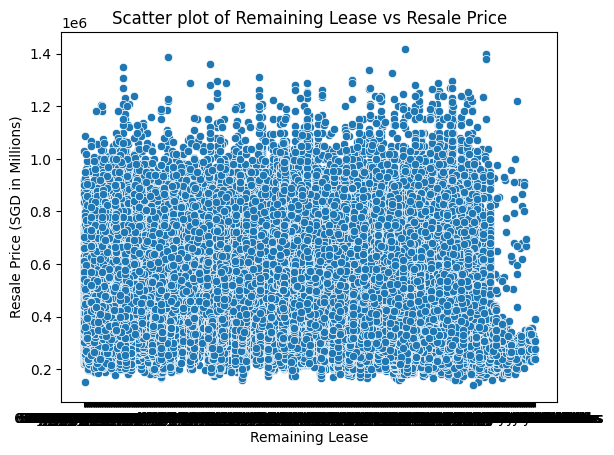

In [18]:
sns.scatterplot(x='remaining_lease', y='resale_price', data=dataset)
plt.title('Scatter plot of Remaining Lease vs Resale Price')
plt.xlabel('Remaining Lease')
plt.ylabel('Resale Price (SGD in Millions)')
plt.show()

## Scatter plot between 'flat_model' and 'resale_price'

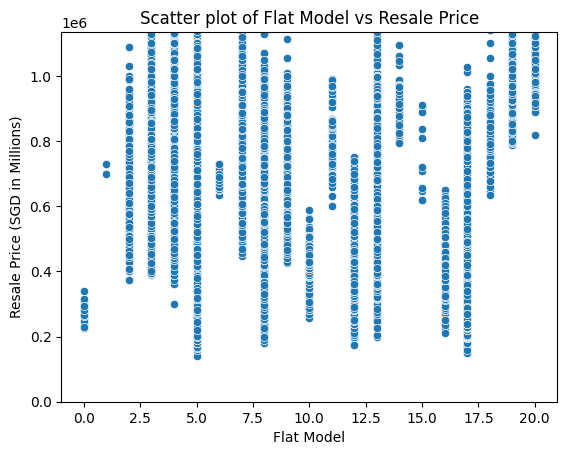

In [19]:
sns.scatterplot(x='flat_model', y='resale_price', data=dataset)
plt.title('Scatter plot of Flat Model vs Resale Price')
plt.xlabel('Flat Model')
plt.ylabel('Resale Price (SGD in Millions)')

# Adjusting the limits of the y-axis
plt.ylim(0, dataset['resale_price'].max() * 0.8)  # Adjust multiplier as needed

plt.show()

## Insights gained from plots

After analyzing the 5 plots provided, it's evident that a clear linear relationship exists between floor area (sqm) vs resale price, as well as flat model vs resale price. However, the remaining 3 plots depicting remaining_lease and lease_commence_date do not seem to exhibit any discernible relationship with resale price.

## Correlation matrix

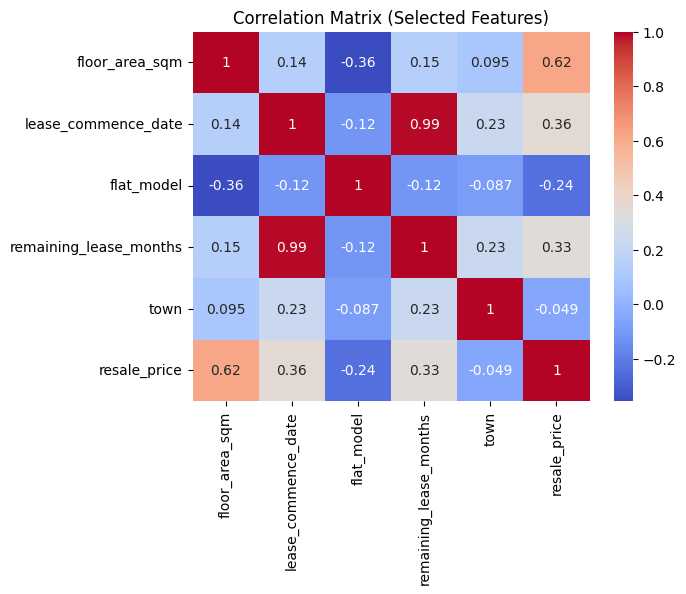

In [20]:
selected_columns = ['floor_area_sqm', 'lease_commence_date', 'flat_model', 'remaining_lease_months', 'town', 'resale_price']
selected_dataset = dataset[selected_columns]

# Calculate correlation matrix
corr_matrix_selected = selected_dataset.corr(numeric_only=True)

# Plotting the correlation matrix
sns.heatmap(corr_matrix_selected, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Selected Features)')
plt.show()


## Correlation results

Based on the correlation matrix, we observe a strong correlation between remaining_lease and lease_commence_date. This finding is expected as the remaining lease duration directly depends on the lease commencement date. Therefore, a higher remaining_lease typically corresponds to a later lease commencement date. As such, we have decided to remove lease_commence_date.

# **Exploring Different Models with Data**


## Linear Regression

Linear Regression Results:
Mean Squared Error: 15858972176.438456
R^2 Score: 0.3969378709319603
Cross-Validation R^2 Scores: [0.40021209 0.39383341 0.38761191 0.38932819 0.39235846]
R^2 Score After Cross-Validation: 0.3926688130149003


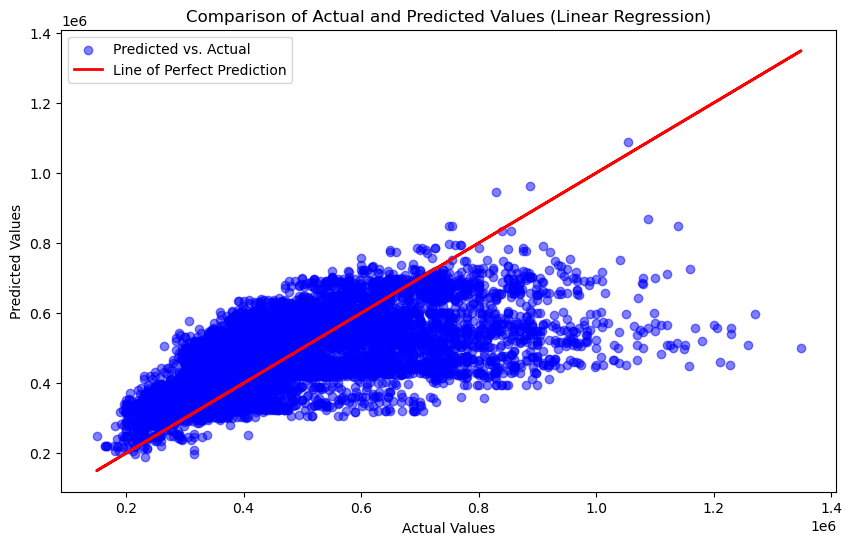

In [15]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Evaluate Linear Regression model
y_pred_linear = linear_model.predict(X_val)
mse_linear = mean_squared_error(y_val, y_pred_linear)
r2_linear = r2_score(y_val, y_pred_linear)

print("Linear Regression Results:")
print(f"Mean Squared Error: {mse_linear}")
print(f"R^2 Score: {r2_linear}")

# Perform k-fold cross-validation
k = 5  # Number of folds
cv_scores = cross_val_score(linear_model, X_train, y_train, cv=k, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R^2 Scores:", cv_scores)
print("R^2 Score After Cross-Validation:", np.mean(cv_scores))

# Plotting for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_linear, color='blue', alpha=0.5, label='Predicted vs. Actual')  
plt.plot(y_val, y_val, color='red', linewidth=2, label='Line of Perfect Prediction')  

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values (Linear Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.show()

## Linear Regression Analysis

The application of linear regression offers us a foundational understanding of the underlying factors influencing resale prices. With a mean squared error of approximately 15.85 billion and an R-squared score of around 0.396 on the validation set, the model demonstrates slightly less than average performance in capturing variations in resale prices. However, this performance indicates that while linear regression can explain a portion of the variance, it might not fully capture the complexity of the hdb market dynamics. The model's reliance on linear relationships between independent variables and the target variable may overlook nonlinear trends and interactions among features which limits its predictive capability.

Additionally, the k-fold cross-validation with five folds corroborates the model's consistency, with R-squared scores consistently hovering around 0.392 across different subsets of the training data. This stability suggests that the linear regression model generalizes reasonably well to unseen data, providing a degree of confidence in its predictive ability. However, it's essential to recognize the limitations of linear regression, such as its sensitivity to outliers and its assumption of independence among predictor variables. These limitations may hinder the model's performance in trying to capture the intricate dynamics of the HDB resale market, particularly in the presence of outliers or multicollinearity among features.

To enhance predictive accuracy and robustness, we will explore more advanced machine learning techniques, such as ensemble methods or nonlinear models like decision trees. These approaches have more flexibility in capturing complex relationships and interactions among features, potentially improving the model's ability to predict resale prices more accurately.

## Random Forest

Random Forest Results:
Mean Squared Error: 3256499421.0769157
R^2 Score: 0.8761665351111977
Cross-Validation R^2 Scores for Random Forest: [0.87679737 0.87730168 0.87738048 0.87649701 0.87946777]
R^2 Score After Cross-Validation: 0.8774888628331196


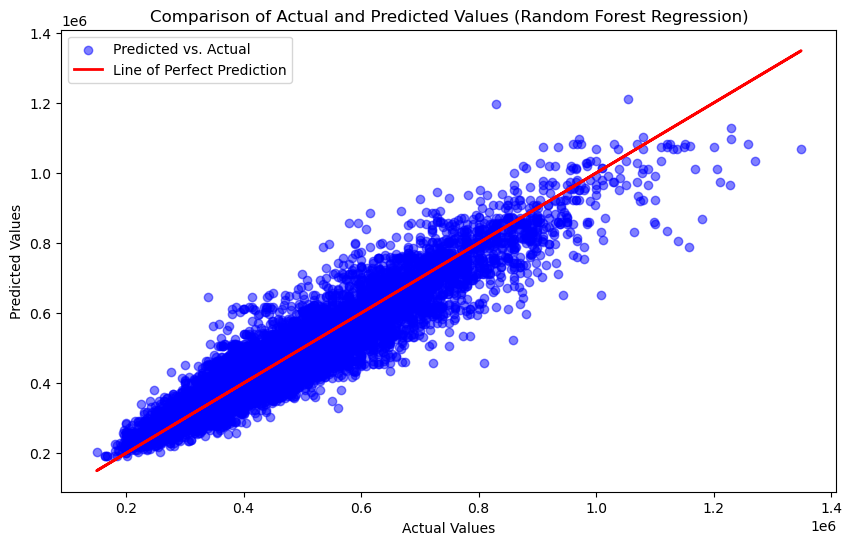

In [16]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_rf = random_forest_model.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print("Random Forest Results:")
print(f"Mean Squared Error: {mse_rf}")
print(f"R^2 Score: {r2_rf}")

# Perform k-fold cross-validation
k = 5  # Number of folds
cv_scores_rf = cross_val_score(random_forest_model, X_train, y_train, cv=k, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R^2 Scores for Random Forest:", cv_scores_rf)
print("R^2 Score After Cross-Validation:", np.mean(cv_scores_rf))

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_rf, color='blue', alpha=0.5, label='Predicted vs. Actual')  
plt.plot(y_val, y_val, color='red', linewidth=2, label='Line of Perfect Prediction') 

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values (Random Forest Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.show()

## Random Forest Analysis

The implementation of Random Forest regression presents a notable improvement in predictive performance compared to linear regression for estimating HDB resale flat prices. With a mean squared error of approximately 3.25 billion and an R-squared score of around 0.876 on the validation set, this model demonstrates superior accuracy in capturing the variability of resale prices. This suggests that Random Forest offers a more nuanced understanding of the housing market dynamics, thereby enhancing predictive capability.

Furthermore, the k-fold cross-validation with five folds reaffirms the robustness of the Random Forest model, with consistently higher R-squared scores around 0.62 across different subsets of the training data. This consistency highlights the model's reliability and generalizability to unseen data, indicating its potential utility as a predictive tool for HDB resale prices. However, it's essential to remain cognizant of potential overfitting and to monitor model performance on unseen data to ensure continuous relevance and accuracy.

## Decision Trees


Decision Tree Results:
Mean Squared Error: 3273171394.494472
R^2 Score: 0.8755325573430864
Cross-Validation R^2 Scores for Decision Tree: [0.87505142 0.87559851 0.87622613 0.87452837 0.87860725]
R^2 After Cross-Validation: 0.8760023361821003


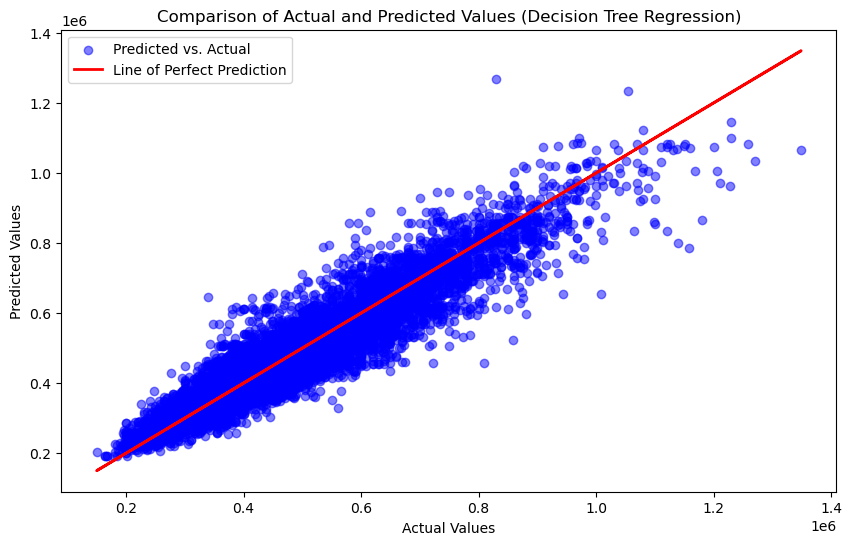

In [17]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)

# Evaluate Decision Tree model
y_pred_dt = decision_tree_model.predict(X_val)
mse_dt = mean_squared_error(y_val, y_pred_dt)
r2_dt = r2_score(y_val, y_pred_dt)

print("\nDecision Tree Results:")
print(f"Mean Squared Error: {mse_dt}")
print(f"R^2 Score: {r2_dt}")

# Perform k-fold cross-validation
k = 5  # Number of folds
cv_scores_dt = cross_val_score(decision_tree_model, X_train, y_train, cv=k, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R^2 Scores for Decision Tree:", cv_scores_dt)
print("R^2 After Cross-Validation:", np.mean(cv_scores_dt))

# Plotting for Decision Tree Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_dt, color='blue', alpha=0.5, label='Predicted vs. Actual')  
plt.plot(y_val, y_val, color='red', linewidth=2, label='Line of Perfect Prediction')  

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values (Decision Tree Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.show()

## Decision Tree Analysis 

The utilization of Decision Trees for predicting HDB resale flat prices provides comparable performance to Random Forest but lacks its ensemble learning advantages. With a mean squared error of approximately 3.27 billion and an R-squared score of around 0.61, this model demonstrates pretty solid predictive capability.

Similar to Random Forest earlier, the k-fold cross-validation with five folds reconfirms the robustness of the Decision Tree model, yielding consistent R-squared scores of around 0.87 across different subsets of the training data. This consistency suggests that Decision Trees generalize well to unseen data. However, it's important to acknowledge the shortcomings of Decision Trees, such as their susceptibility to high variance and their inability to capture complex relationships among features.

## SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

# Assuming dataset is a DataFrame containing your data
# Randomly sample 1% of the dataset(just checking if able to run)
smaller_dataset = dataset.sample(frac=0.01, random_state=42)

# If you need to reset the index of the smaller dataset
smaller_dataset.reset_index(drop=True, inplace=True)

# Split the smaller dataset into features (X) and target variable (y)
X = dataset[['flat_type', 'flat_model', 'floor_area_sqm']]  
y = dataset['resale_price']  

# Split the smaller dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVM regressor
svm_regressor = SVR(kernel='rbf', C=10) #higher the C, the less tolerant it is for misclassification.

# Train the SVM regressor
svm_regressor.fit(X_train, y_train)

# Predict the target values for validation set before optimization
y_pred_svm_pre_optimization = svm_regressor.predict(X_val)

# Evaluate SVM regressor before optimization
mse_svm_pre_optimization = mean_squared_error(y_val, y_pred_svm_pre_optimization)
r2_svm_pre_optimization = r2_score(y_val, y_pred_svm_pre_optimization)

# Print pre-optimized results
print("\nSupport Vector Machine Results (Pre-Optimization):")
print(f"Mean Squared Error: {mse_svm_pre_optimization}")
print(f"R^2 Score: {r2_svm_pre_optimization}")

# Define the parameter grid for grid search
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': ['scale', 'auto']}

# Initialize the SVM regressor
svm_regressor = SVR()

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Train the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_svm_regressor = grid_search.best_estimator_

# Predict the target values for validation set using the best estimator
y_pred_svm = best_svm_regressor.predict(X_val)

# Evaluate the optimized SVM regressor
mse_svm_optimized = mean_squared_error(y_val, y_pred_svm)
r2_svm_optimized = r2_score(y_val, y_pred_svm)

# Print optimized results
print("\nSupport Vector Machine Results (Optimized):")
print(f"Mean Squared Error: {mse_svm_optimized}")
print(f"R^2 Score: {r2_svm_optimized}")



## Gradient Boosting Model (Ada Boost)


ADA Boost Results:
Mean Squared Error: 20185109876.585133
R^2 Score: 0.23242974373012093
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 50}
Optimised R^2 Score: 0.4520462664790347


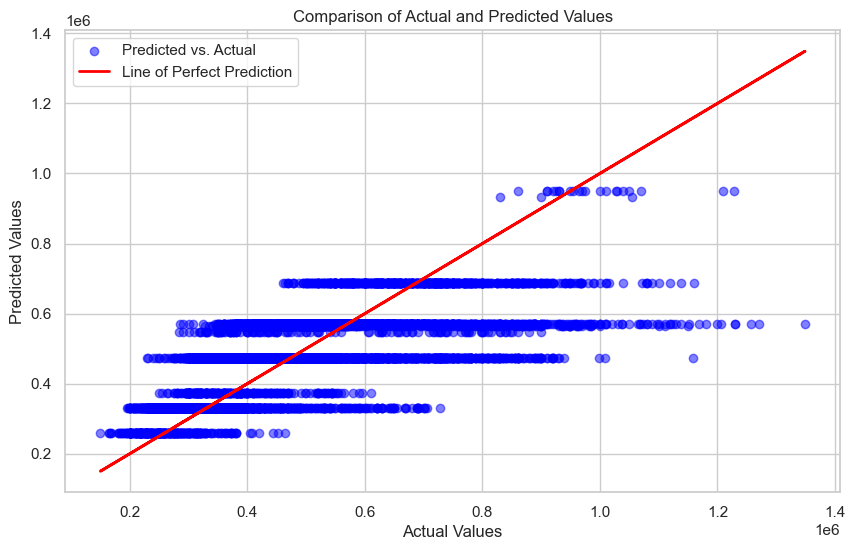

In [32]:
ada_regressor = AdaBoostRegressor(random_state=42, n_estimators=50)
ada_regressor.fit(X_train, y_train)

y_pred = ada_regressor.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("\nADA Boost Results:")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

ada_regressor = AdaBoostRegressor(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'learning_rate': [0.01, 0.05, 0.1],  # Weight applied to each classifier at each boosting iteration
    'loss': ['linear', 'square', 'exponential']  # The loss function to use when updating weights
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=ada_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print out the best parameters
print("Best parameters found: ", best_params)

# Use the best model to make predictions
y_pred = best_model.predict(X_val)

new_r2 = r2_score(y_val, y_pred)

# Print the results
print(f"Optimised R^2 Score: {new_r2}")

# Setting up the visual style
sns.set(style="whitegrid")

# Assuming y_val are the actual values and y_pred are the predicted values from your model
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, color='blue', alpha=0.5, label='Predicted vs. Actual')  # Scatter plot for actual vs predicted
plt.plot(y_val, y_val, color='red', linewidth=2, label='Line of Perfect Prediction')  # Line for perfect predictions

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.show()

## Ada Boost Analysis


## Gradient Boosting Model (Gradient Boosting Regressor)

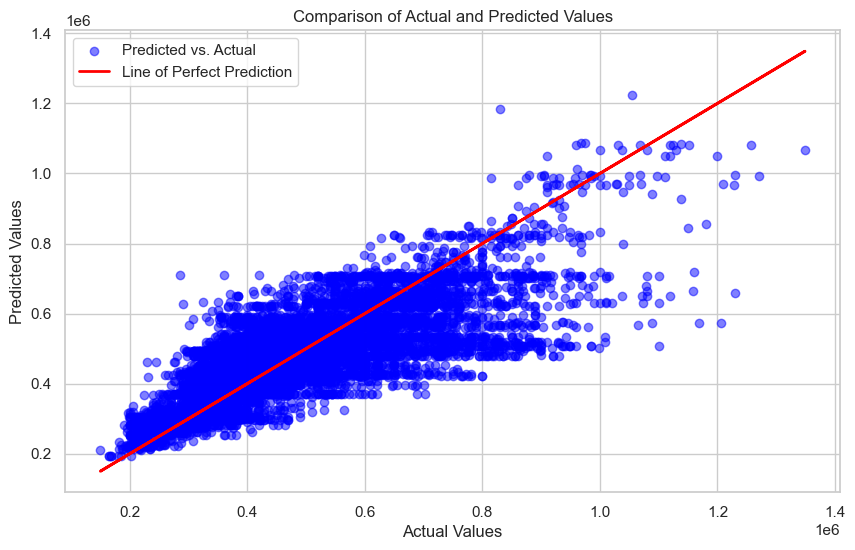

In [31]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("\nGBR results:")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

gbr = GradientBoostingRegressor(random_state=42)

# Define the scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, scoring=mse_scorer, cv=5, n_jobs=-1, verbose=1)

# Fit to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

new_r2 = r2_score(y_val, y_pred)

# Print the results
print(f"Optimised R^2 Score: {new_r2}")

# Setting up the visual style
sns.set(style="whitegrid")

# Assuming y_val are the actual values and y_pred are the predicted values from your model
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, color='blue', alpha=0.5, label='Predicted vs. Actual')  # Scatter plot for actual vs predicted
plt.plot(y_val, y_val, color='red', linewidth=2, label='Line of Perfect Prediction')  # Line for perfect predictions

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Show the plot
plt.show()

## Gradient Boosting Regressor 

## Model Comparison

Among the various models evaluated for predicting HDB resale flat prices, the Gradient Boosting Regressor emerges as the most promising choice, exhibiting superior performance in terms of Mean Squared Error (MSE) and predictive accuracy. With a significantly lower MSE compared to other models like Linear Regression and Ada Boost, the Gradient Boosting Regressor demonstrates its ability to provide more precise estimations of resale flat prices. 

Additionally, its higher R-squared score highlights its effectiveness in capturing complex relationships within the dataset, suggesting that it can better explain the variability in resale prices than the other models. This enhanced predictive capability is crucial for researchers who are keeping track of HDB resale market, providing them with more reliable insights for decision-making.

# Extra Features

## Utilising the distance from MRT to HDB to predict resale prices

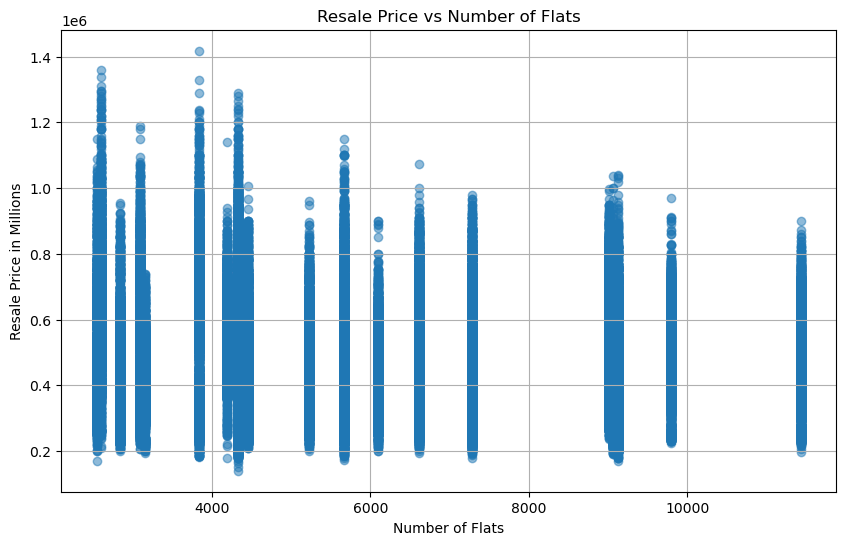

In [18]:
hdb_dataset = pd.read_csv(r"..\CS3244-Machines-That-Learn\Dataset\resale_flat.csv")

# Load the MRT/LRT station dataset
mrt_dataset = pd.read_csv(r"..\CS3244-Machines-That-Learn\Dataset\mrt_lrt_data.csv")

# Convert the station names in the MRT/LRT station dataset to all capital letters
mrt_dataset['station_name'] = mrt_dataset['station_name'].str.upper()

# Merge the HDB resale dataset with the MRT/LRT station dataset based on the town name
merged_dataset = pd.merge(hdb_dataset, mrt_dataset, left_on='town', right_on='station_name', how='left')

# Group the merged dataset by the station name and count the number of flats in each group
station_counts = merged_dataset.groupby('station_name').size().reset_index(name='Number of Flats')

# Merge the station counts with the original MRT/LRT station dataset to include stations with zero flats
mrt_dataset_with_counts = pd.merge(mrt_dataset, station_counts, on='station_name', how='left')

# Fill missing values in the "Number of Flats" column with zero
mrt_dataset_with_counts['Number of Flats'].fillna(0, inplace=True)

# Merge the MRT/LRT station dataset with the HDB resale dataset based on the town name
hdb_dataset_with_counts = pd.merge(hdb_dataset, mrt_dataset_with_counts[['station_name', 'Number of Flats']], left_on='town', right_on='station_name', how='left')

# Drop the redundant "station_name" column
hdb_dataset_with_counts.drop(columns=['station_name'], inplace=True)

plt.figure(figsize=(10, 6))
plt.scatter(hdb_dataset_with_counts['Number of Flats'], hdb_dataset_with_counts['resale_price'], alpha=0.5)
plt.title('Resale Price vs Number of Flats')
plt.xlabel('Number of Flats')
plt.ylabel('Resale Price in Millions')


plt.grid(True)
plt.show()

In our efforts to enhance the predictive power of our HDB resale dataset, we introduced an extra feature called 'Number of Flats'. This feature aims to quantify the density of hdb units in proximity to designated MRT stations, offering insights into the housing landscape's relationship with transportation infrastructure. To achieve this, we integrated an additional dataset containing MRT station information from kaggle, including the station names, which align with the town column in our HDB dataset.

Upon merging both datasets, we conducted a thorough analysis by plotting the resale_price against the number of flats. Surprisingly, our findings revealed a negative linear relationship between these variables. As the number of flats near the MRT station increases, the resale price of the flats tends to decrease. This counterintuitive observation challenges our initial assumptions, as conventional wisdom would suggest that being near to an MRT station enhances a property's value due to the convenience it offers for transportation.

Beyond this module, we could delve deeper to understand the underlying factors contributing to this phenomenon. Potential considerations include the quality of amenities, neighborhood demographics, and infrastructure developments. By delving deeper into these aspects, we can potentially uncover hidden dynamics driving housing prices in proximity to MRT stations.

## Utilising the number of nearby primary schools

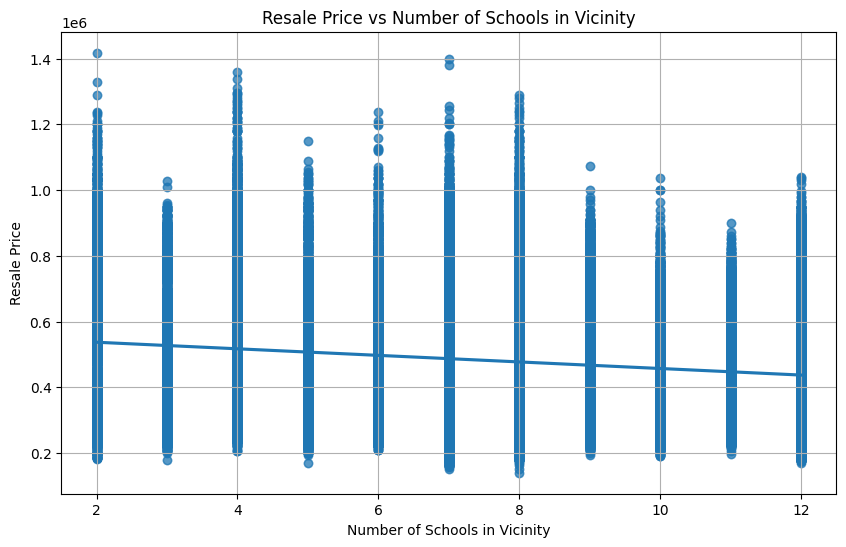

In [20]:
pri_school_data = pd.read_csv(r"../CS3244-Machines-That-Learn/Dataset/pri_sch_clean.csv")
hdb_data = pd.read_csv(r"../CS3244-Machines-That-Learn/Dataset/resale_flat.csv")
hdb_data['town'] = hdb_data['town'].str.upper()
pri_school_data['Area'] = pri_school_data['Area'].str.upper()

# Count the number of primary schools in each area
school_count = pri_school_data.groupby('Area').size().reset_index(name='school_count')

# Merge the school count with the HDB data
hdb_data = pd.merge(hdb_data, school_count, left_on='town', right_on='Area', how='left')


plt.figure(figsize=(10, 6))
plt.scatter(hdb_data['school_count'], hdb_data['resale_price'], alpha=0.5)
sns.regplot(x='school_count', y='resale_price', data=hdb_data, scatter_kws={'alpha':0.5})
plt.title('Resale Price vs Number of Schools in Vicinity')
plt.xlabel('Number of Schools in Vicinity')
plt.ylabel('Resale Price')
plt.grid(True)
plt.show()